In [1]:
import itertools

from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.animation
import mpl_toolkits.mplot3d.art3d as art3d
import numpy as np
import pandas as pd
import scipy, scipy.interpolate
import sqlite3

import IPython.display

%matplotlib inline

# A Brief Introduction to Path Signatures

### Peter Foster

#### The Alan Turing Institute

#### Version 0.2.0 (updated by Ryan Chan)

This notebook is intended as a brief introduction to **path signatures** for machine learning practitioners. In a nutshell, path signatures are fixed-length feature vectors which we may for example use to represent multi-dimensional time series, where samples in the time series need not be evenly spaced in time. Because there is a non-linear relationship between the components of a path signature and the signal that it represents, path signatures are entirely different to Fourier or Wavelet coefficients. Path signature features have been observed to perform competitively in machine learning tasks such as human action recognition (Yang et al., 2017), character recognition (Diehl, 2013; Graham, 2013), handwriting recognition (Yin et al., 2013), financial time series classification (Gyurkó et al., 2013), classification of medical disorders and conditions (Arribas et al., 2018; Morrill et al., 2019), crop yield prediction (Lemercier et al., 2020). More broadly, path signatures have also been applied to create novel approaches in topological data analysis (Chevyrev et al., 2018), independent component analysis (Oberhauser and Schnell, 2021), as well as serving as a feature map in neural networks (Wang et al. 2019). Another notable characteristic of path signatures is that the features are (in principle) interpretable.

The content of this notebook draws substantially from the excellent primer by Chevyrev and Kormilitzin (2016). This notebook assumes only basic calculus as a prerequisite, with an emphasis on providing visual examples. The focus of this notebook is on introducing the concepts of paths and streams, the path signature, and path transformations. For illustrative purposes, we will initially consider 1-dimensional paths. Note however that path signatures are particularly useful when dealing with multi-dimensional paths.

## Paths

A path is a function which maps an interval onto $N$-dimensional Euclidean space. Consider the path $f(t) = (t-1)^3, t \in [0, 2]$ which we interpret as a function of time. This is an example of a path with dimensionality $N=1$.

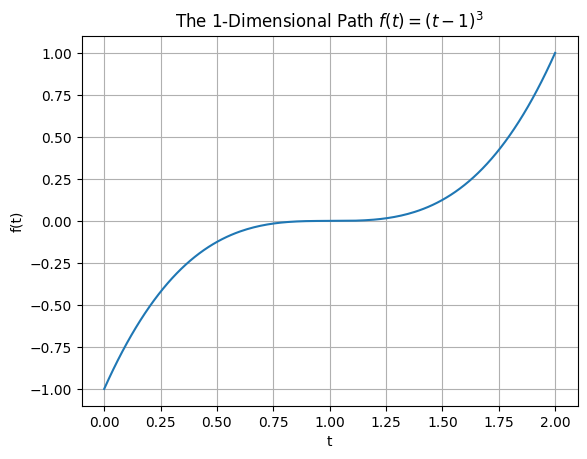

In [2]:
f = lambda t: (t - 1)**3
t = np.linspace(0, 2, 200)

# plot the path
plt.plot(t, f(t))
plt.xlabel('t')
plt.ylabel('f(t)')
plt.title('The 1-Dimensional Path $f(t) = (t-1)^3$')
plt.grid()
plt.show()

In fact, many practical applications of paths involve time as the domain. Consider a person writing the digit **2** on a touchscreen. This is an example of the 2-dimensional path 
$$
\mathbf{g}(t) = (x(t), y(t)),
$$
where $x(t)$ and $y(t) respectively represent the horizontal and vertical screen position at time $t$. Note that $x(t)$ and $y(t)$ are themselves one-dimensional paths.

This concrete example is taken from an online digit gesture recognition dataset (Corr et. al, 2017):

In [3]:
# read data corresponding to a single glyph entry, for a given user
conn = sqlite3.connect('data/corr_numeral_gesture_dataset/database.sqlite')
df = pd.read_sql_query(
    "SELECT zglyph.zindex, zglyph.zsubject, zglyph.zcharacter, zglyph.zduration, "
    "ztouch.ztimestamp, ztouch.zx, ztouch.zy "
    "FROM zglyph, zstroke, ztouch "
    "WHERE zstroke.zglyph=zglyph.z_pk AND ztouch.zstroke=zstroke.z_pk "
    "AND zglyph.zsubject=1 AND zglyph.zcharacter=2;",
    conn
)

# process the data
df = df[df['ZINDEX'] == df['ZINDEX'].unique()[2]]
df = df[['ZTIMESTAMP', 'ZX', 'ZY']].set_index('ZTIMESTAMP', drop=True).sort_index()

# process the data for playback
PLAYBACK_SPEED = 0.33
df.index = df.index / PLAYBACK_SPEED
FRAME_RATE=40
t = np.arange(df.index.min(), df.index.max(), 1/FRAME_RATE)
df = df.reindex(df.index.union(t)).interpolate().loc[t]

# set up the plot
fig, ax = plt.subplots()
ax.set_xlim(0, 300)
ax.set_ylim(400, 0)
ax.set_xlabel('x(t)')
ax.set_ylabel('y(t)')
ax.set_title('The 2-Dimensional Path $\mathbf{g}(t) = (x(t), y(t))$\n'
             'for a person drawing the digit "2" on a touchscreen')
ax.grid()
line_plot, = ax.plot([],[], alpha=0.15)
scatter_plot = ax.scatter([], [], color='k')
text_box = ax.text(250, 50, '', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# animate the plot
def animate(i):
    selected_data = df.iloc[:int(i+1)]
    line_plot.set_data(selected_data['ZX'], selected_data['ZY'])
    scatter_plot.set_offsets(selected_data[['ZX', 'ZY']].iloc[i])
    text_box.set_text('t={:.1f}s'.format(df.index[i]))
anim = matplotlib.animation.FuncAnimation(fig, animate, len(df), interval=1000/FRAME_RATE)

plt.close(fig)
IPython.display.HTML(anim.to_jshtml())

Note that we visualised the 1-D path using a 2-D plot of $f(t)$ against $t$, whereas we visualised the 2-D path using a 2-D animation of $\mathbf{g}(t)$ against $t$. If we want to ensure that we retain all timing information, we require N+1 dimensions to describe the trajectory of an N-dimensional path, because we need to include the path's domain.

## Data Streams

Also, note that both preceding examples elide an important fact: Whereas we typically deal with data *sampled at discrete times*, the domain of a path is continuous. For this reason, we define an $N$-dimensional **data stream** as a sequence of points in $N$-dimensional Euclidean space which we observe at discrete times $t_1<t_2 <\ldots< t_M$. To obtain a path from a data stream, it is necessary that we interpolate between successive points. Using the example of our 1-dimensional path $f(t) = (t-1)^3, t \in [0, 2]$ for which we obtain a time series consisting of $M=8$ evenly spaced samples, the following figure shows different interpolation strategies that we might apply:

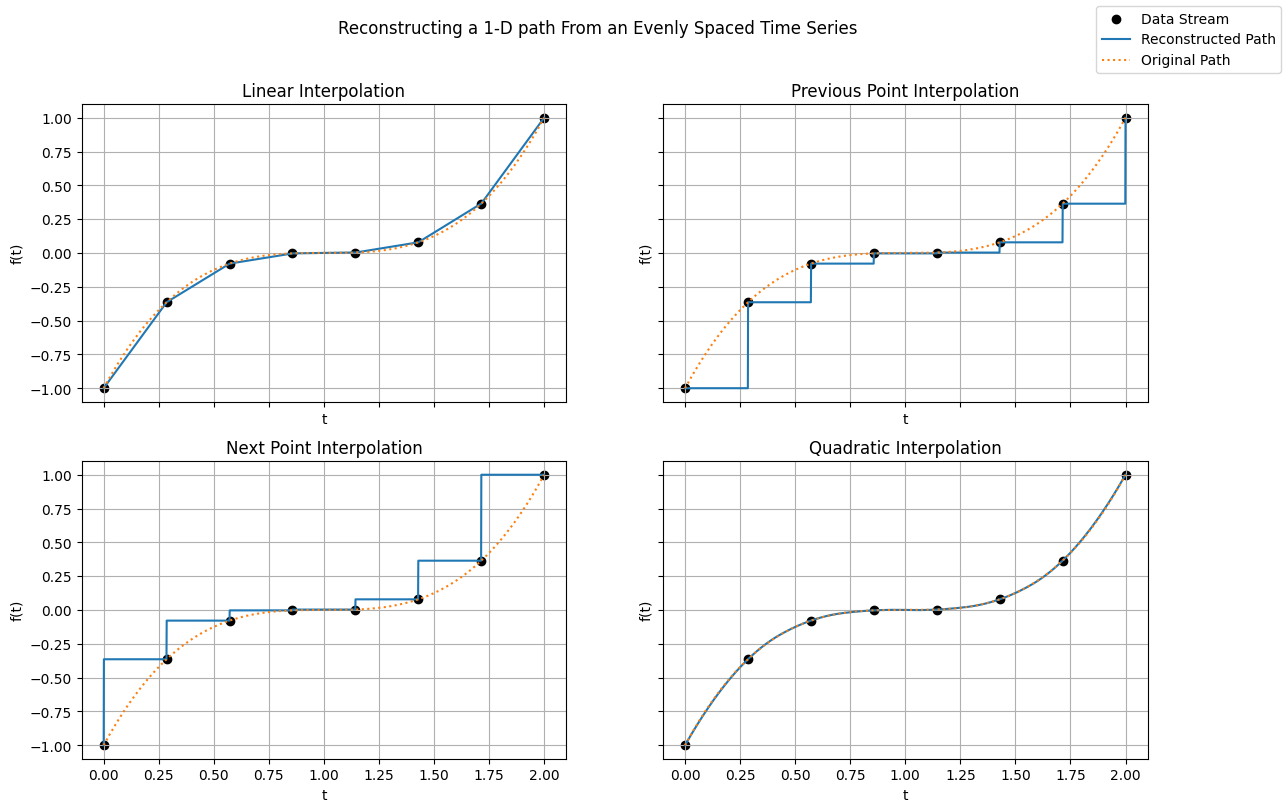

In [4]:
f = lambda t: (t - 1)**3
t = np.linspace(0, 2, 2000)
t_samples = np.linspace(0, 2, 8)

interpolation_methods = (('linear', 'Linear Interpolation'),
                         ('previous', 'Previous Point Interpolation'),
                         ('next', 'Next Point Interpolation'),
                         ('quadratic', 'Quadratic Interpolation'))

# initialize the figure
figure_height = 8.5
fig, ax = plt.subplots(2, 2, figsize=(figure_height * scipy.constants.golden_ratio, figure_height),
                     sharex=True, sharey=True)

# create a plot for each interpolation method
for method, ax in zip(interpolation_methods, ax.flatten()):
    # interpolate the path using the given method
    f_interpolated = scipy.interpolate.interp1d(t_samples, f(t_samples), kind=method[0])

    # plot the data points and the interpolated path
    p_time_series = ax.scatter(t_samples, f(t_samples), color='k')
    p_reconstructed, = ax.plot(t, f_interpolated(t))
    p_original, = ax.plot(t, f(t), linestyle=':')
    
    # set the axis labels and title
    ax.set_xlabel('t')
    ax.set_ylabel('f(t)')
    ax.set_title('{}'.format(method[1]))
    ax.grid()

# create a legend
fig.legend([p_time_series, p_reconstructed, p_original], ['Data Stream', 'Reconstructed Path', 'Original Path'])
plt.suptitle('Reconstructing a 1-D path From an Evenly Spaced Time Series')
plt.show()

Our definition of a data stream does not require that its samples are spaced evenly in time. For example, we may linearly interpolate a path from the following data:

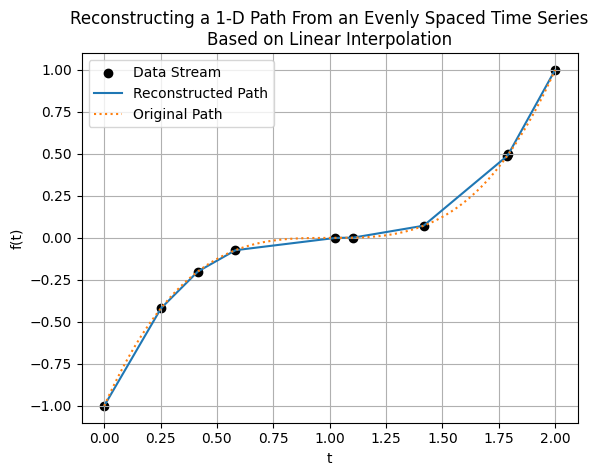

In [5]:
f = lambda t: (t - 1)**3
t = np.linspace(0, 2, 2000)
np.random.seed(3)
t_samples = np.random.uniform(0, 2, size=8)
t_samples = np.insert(t_samples, [0, -1], [t[0], t[-1]])
reconstuctable_samples_mask = (t > min(t_samples)) & (t < max(t_samples))

# linear interpolation of the path
interpolation_method = ('linear', 'Linear Interpolation')
f_interpolated = scipy.interpolate.interp1d(t_samples, f(t_samples), kind=interpolation_method[0])

# plot the path
p_time_series = plt.scatter(t_samples, f(t_samples), color='k')
p_reconstructed, = plt.plot(t[reconstuctable_samples_mask], f_interpolated(t[reconstuctable_samples_mask]))
p_original, = plt.plot(t, f(t), linestyle=':')

# add labels and legend
plt.xlabel('t')
plt.ylabel('f(t)')
plt.title('{}'.format(method[1]))
plt.legend([p_time_series, p_reconstructed, p_original], ['Data Stream', 'Reconstructed Path', 'Original Path'])
plt.title('Reconstructing a 1-D Path From an Evenly Spaced Time Series\nBased on Linear Interpolation')
plt.grid()
plt.show()

### Definition of a Path

Having considered two examples of paths and their relation to data streams, henceforth we will assume that our paths are piecewise differentiable. This assumption is sufficient to allow us to define the path signature (Chen, 1958) as a series of iterated integrals.

*Side remark*: The preceding examples which we considered are all piecewise differentiable. By contrast, rough path theory (Lyons, 1998) deals with the case where this assumption does not hold, due to the path being highly irregular, as encountered for example in some types of stock prices. (A formal definition of the amount of irregularity in a function is its $p$-variation). A key contribution of rough path theory is that for such paths it is still possible to obtain the path signature in a well-defined sense.

Henceforth, we will use the following capital letter notation for paths: We define an $N$-dimensional path as the mapping $X: [a, b] \to \mathbb{R}^N$. Furthermore, we will use the notation $X_t = X(t)$ to denote the dependence of $X$ on $t \in [a, b]$.

## Path Integrals

Given 1-D paths $X_t, Y_t$ and defining $X'_t = dX_t/dt$, we define the path integral
$$\int_a^b Y_t \, X'_t \, dt := \int_a^b Y_t \, dX_t.$$

We can interpret the path integral as the area that we obtain when plotting $Y_t$ against $X_t$ for $t$ in the interval $[a, b]$. Using the example of paths $X_t=t$ and $Y_t = cos(t)$, $t \in [0, 2\pi]$, the following plot illustrates the geometric interpretation of the path integral. In the plot, we use green and red shading to denote positive and negative contributions towards the total area, respectively; try varying the limits of the integral by manipulating the sliders:

In [6]:
def plot_Y_against_X(a, b, X, Y, xlim, ylim, title):
    # function to plot Y against X, and shade the area under the curve
    t = np.linspace(a, b, 200)
    X_t = X(t)
    Y_t = Y(t)
    dX_t = np.diff(X(t))
    dX_t = np.append(dX_t, dX_t[-1])
    
    plt.plot(X_t, Y_t, color='black')
    plt.fill_between(X_t, Y_t, where=~(Y_t >= 0) ^ (dX_t >= 0), facecolor='green', interpolate=True)
    plt.fill_between(X_t, Y_t, where=(Y_t >= 0) ^ (dX_t >= 0), facecolor='red', interpolate=True)
    
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.xlabel('$X_t$')
    plt.ylabel('$Y_t$')
    plt.title(title)
    plt.grid()
    plt.gca().set_aspect('equal', adjustable='box')

# create sliders for the start and end points of the path
Slider = lambda value: widgets.SelectionSlider(options=[("{:.4}".format(i), i)
                                                        for i in sorted(np.append(np.linspace(0, np.pi*2), value))],
                                               continuous_update=False, value=value)

interact(lambda a, b: plot_Y_against_X(a, b,
                                       X=lambda t: t, Y=lambda t: np.cos(t),
                                       xlim=(0, np.pi*2), ylim=(-1.1, 1.1),
                                       title='Geometric interpretation of the path integral $\int_{a}^{b} Y_t \, dX_t$\n'
                                             'for $Y_t=cos(t)$, $X_t=t$ '
                                             'based on plotting $Y_t$ against $X_t$'),
         a=Slider(value=0),
         b=Slider(value=np.pi/2));

interactive(children=(SelectionSlider(continuous_update=False, description='a', options=(('0.0', 0.0), ('0.0',…

Of course, the preceding example is relatively straightforward, in that we consider the straight line $X_t = t$, whose slope is $1$; the path integral is thus equivalent to
$$\int_a^b Y_t \, X'_t \, dt  = \int_a^b Y_t \, dt$$
which has the familiar interpretation as the area under the curve that we obtain by plotting $Y_t$ against $t$, for $t$ in the interval $[a, b]$.

As a more involved example, let us now consider the path integral of $Y_t = cos(t)$ with respect to $X_t = sin(t)$. In this case, $X_t$ is no longer a straight line. Nonetheless, we are able to accumulate area between the boundary given by the unit circle and the axis given by $X_t$, even as $X_t$ retraces itself. Again, try varying the limits of the integral by manipulating the sliders. Note that in this example, providing that $b > a$, the area is positive.

In [7]:
interact(lambda a, b: plot_Y_against_X(a, b,
                                       X=lambda t: np.sin(t), Y=lambda t: np.cos(t),
                                       xlim=(-1.1, 1.1), ylim=(-1.1, 1.1),
                                       title='Geometric interpretation of the path integral $\int_{a}^{b} Y_t \, dX_t$\n'
                                             'for $Y_t=cos(t)$, $X_t=sin(t)$ '
                                             'based on plotting $Y_t$ against $X_t$'),
         a=Slider(value=0),
         b=Slider(value=np.pi/2));

interactive(children=(SelectionSlider(continuous_update=False, description='a', options=(('0.0', 0.0), ('0.0',…

The third instance of a path integral that we will consider is the case where $Y_t = 1$. In this case, the path integral of $Y_t$ with respect to $X_t$ simplifies as
$$\int_a^b Y_t \, X'_t \, dt = \int_a^b X'_t \, dt = X_b - X_a$$
which is simply the increment of path $X$ over the interval $[a, b]$. For completeness, the following plot of $X_t$ against $t$ illustrates the geometric interpretation of the path increment, based on $X_t = sin(t)$, $t \in [0, 2\pi]$. We use a vertical coloured line to represent the path increment, using the colours green and red to represent positive and negative path increments, respectively:

In [8]:
def plot_X_against_t(a, b, X, tlim, xlim, title):
    # function to plot X against t, and shade the area under the curve
    t = np.linspace(a, b, 200)
    X_t = X(t)
    
    plt.plot(t, X_t)
    plt.scatter([a, b], [X(a), X(b)], color='k')
    plt.hlines([X(a), X(b)], tlim[0], tlim[1], linestyle=':', color='gray')
    plt.vlines(tlim[1] - 0.25, X(a), X(b), linewidth=3, color=('green' if X(b) >= X(a) else 'red'))
    
    plt.xlim(*tlim)
    plt.ylim(*xlim)
    plt.xlabel('$t$')
    plt.ylabel('$X_t$')
    plt.title(title)
    plt.grid()
    plt.gca().set_aspect('equal', adjustable='box')

interact(lambda a, b: plot_X_against_t(a, b,
                                       X=lambda t: np.sin(t),
                                       tlim=(0, np.pi*2 + 0.5),
                                       xlim=(-1.1, 1.1),
                                       title='Geometric interpretation of the path integral $\int_{a}^{b} Y_t \, dX_t$\n'
                                             'for $X_t=sin(t)$, $Y_t=1$ '
                                             'based on plotting $X_t$ against $t$'),
         a=Slider(value=0),
         b=Slider(value=np.pi/2));

interactive(children=(SelectionSlider(continuous_update=False, description='a', options=(('0.0', 0.0), ('0.0',…

### Properties of Path Integrals

There are two important properties of path integrals, namely **translation invariance** and **reparametrisation invariance**.

#### Translation Invariance

The value of the path integral integral $\int_a^b Y_t \, dX_t$ is invariant to $X_a$. In other words, it doesn't matter if we shift the entire path $X_t$:
$$
\int_a^b Y_t \, dX_t = \int_a^b Y_t \, dZ_t
$$
where $Z_t := X_t + c$ and $c$ is some constant.

#### Reparametrisation Invariance

For the path integral $\int_a^b Y_t \, dX_t$, this property relates to the fact that instead of integrating with respect to $t$, in the above equation we integrate with respect to the  path $X_t$. For the case where $t$ represents time, reparametrisation invariance implies that the path integral is invariant to the (instantaneous) speed at which $X_t$ is traced.

### Path Integrals as Paths

From the preceding plots, it should come as little surprise that we may treat the path integral itself as a path whose domain is the upper limit (or analogously the lower limit) of the integral. That is, given paths $X_t$ and $Y_t$ with $t \in [a, b]$, we may define the path $Z_c$ with $c \in [a, b]$,
$$Z_c := \int_a^c Y_t \, dX_t.$$

Path integrals are in fact the 'building blocks' of the path signature, which we are now ready to introduce.

## Path Signatures

At an informal level, the signature of an $N$-dimensional path is an ordered set comprising all possible path integrals that we can construct involving combinations of the path's individual 1-dimensional coordinate paths.

Aiming at a more precise definition, let us consider the $N$-dimensional path $X_t, t \in [a, b]$. We will use the superscript notation $X_t = (X_t^1, \ldots, X_t^N)$ to denote the 1-dimensional coordinate paths which comprise $X$. We will assume that each coordinate path is quantified in 1-dimensional units, for example distance units.

To obtain the path signature, based on our preceding discussion of path integrals we first obtain the increments of $X^1, \ldots, X^N$ over the interval $[a, t]$ with $t \in [a, b]$, which we denote using $S(X)^1_{a, t}, \ldots, S(X)^N_{a, t}$, 
$$
S(X)^n_{a, t} :=  \int_a^{t} dX^n_c.
$$
Based on our preceding assumptions, these first order integrals are each quantified in 1-dimensional units. As was mentioned previously, we may interpret $S(X)^n_{a, t}$ itself as a path.

We next obtain those integrals involving two paths, with one path a coordinate path $X^m_t$ and the other path the increment $S(X)^n_{a, t}$ of the coordinate path $X_t^n$. These path integrals are quantified using 2-dimensional units, for example area units. There are $N^2$ such second order integrals, which we denote using $S(X)^{1,1}_{a, t} \ldots, S(X)^{N,N}_{a, t}$,
$$
S(X)^{n,m}_{a, t} := \int_a^t S(X)^n_{a, c} \, dX^m_c.
$$

We may interpret these second order integrals as the area that we obtain when plotting $S(X)^n_{a, c}$ against $X^m_c$ over the interval $[a, t]$ and with $t \in [a, b]$.

The set of first order integrals (comprising $N$ integrals) and the set of second order integrals (comprising $N^2$ integrals) respectively are in fact the first and second levels of the **path signature**. Continuing the process of obtaining path integrals iteratively, there are $N^k$ possible integrals of order $k$ which together form the $k$th level of the path signature; we may use the multi-index $i_1, \ldots, i_k$ to refer to the $k$th order path integral $S(X)^{i_1, \ldots, i_k}_{a, t}$,
$$
S(X)^{i_1, \ldots, i_k}_{a, t} := \int_a^t S(X)^{i_1, \ldots, i_{k-1}}_{a, c} \, dX^{i_k}_c.
$$
The path signature $S(X)_{a,b}$ is the infinite ordered set of terms that we obtain by considering all levels $k \geq 0$ and with respect to the path's domain $[a, b]$: 
$$
S(X)_{a,b} := (1, S(X)^1_{a, b}, S(X)^2_{a, b}, \ldots, S(X)^N_{a, b}, S(X)^{1, 1}_{a, b}, S(X)^{1, 2}_{a, b}, \ldots, S(X)^{N, N}_{a, b}, S(X)^{1, 1, 1}_{a, b}, \ldots)
$$
where the initial term is equal to $1$ by convention, corresponding to the zeroth level. In practice, we obtain a finite number of terms by truncating the signature after a specified level $K$.

Because the path signature consists of iterated path integrals, it inherits their properties of **translation invariance** and **reparametrisation invariance**. For applications such as handwriting recognition, where we do not care about the absolute position or speed at which a path is executed, both translation invariance and reparametrisation invariance are useful properties. However, should we require the path signature to be sensitive to translation and/or reparametrisation, there are transformations that we can apply as a pre-processing step. We describe these transformations later on in this notebook.

Why is the path signature a useful representation? To gain some loose intuition from a probabilistic perspective, assume that we have probability density functions $q^1, \ldots q^N$ each with support $[a, b]$ corresponding to the independent random variables $T^1 \ldots T^N$. We then construct the path $Q_t=(Q^1_t, \ldots, Q^n_t)$, where $Q^n_t$ is the probability associated with the outcome $T^n \leq t$. That is, $Q^n$ is a cumulative distribution function. Based on these assumptions, for the first order integrals $S(Q)^1_{a, t}$ we have
$$
S(Q)^n_{a, t} = Q^n_t - Q^n_a = \text{Pr}(a < T^n \leq t)
$$
i.e. the probability that $T^n$ lies in the interval $(a, t]$. For the second order integrals $S(Q)^{n,m}_{a, t}$, recall that we may equivalently write 
$$
S(Q)^{n,m}_{a, t} = \int_a^t S(Q)^n_{a, c} Q'^m_c \, dc = \int_a^t \text{Pr}(a < T^n \leq c) q^m(c) \, dc.
$$
The latter is equivalent to the probability of jointly observing $a < T^n \leq T^m \wedge  a \leq T^m \leq t$,
$$
S(Q)^{n,m}_{a, t} = \text{Pr}(a < T^n \leq T^m \leq t).
$$
For the $k$th order path integral $S(Q)^{i_1, \ldots, i_k}_{a, t}$, it follows that we may write
$$
S(Q)^{i_1, \ldots, i_k}_{a, t} = \int_a^t S(Q)^{i_1, \ldots, i_{k-1}}_{a, c} Q'^k_c \, dc = \int_a^t \text{Pr}(a < T_1^{i_1} \leq \ldots \leq T_{k-1}^{i_{k-1}}\leq c) q^k(c) \, dc = \text{Pr}(a < T_1^{i_1} \leq \ldots \leq T_{k}^{i_{k}}\leq t)
$$
where we have used the subscript notation $T^n_j$ to denote independent and identically distributed random variables associated with the probability density function $q^n$. Thus, for the specific case where our coordinate paths are cumulative distribution functions, the signature $S(Q)_{a,b}$ consists of the terms
$$
S(Q)_{a,b} = (1, \\ \text{Pr}(a < T_1^1 \leq b), \text{Pr}(a < T_1^2 \leq b), \ldots, \text{Pr}(a < T_1^N \leq b),\\
\text{Pr}(a < T_1^1 \leq T_2^1 \leq b), \text{Pr}(a < T_1^1 \leq T_2^2 \leq b), \ldots, \text{Pr}(a < T_1^N \leq T_2^N \leq b), \\ \text{Pr}(a < T_1^1 \leq T_2^1 \leq T_3^1 \leq b), \ldots)
$$
where we note that the terms at level $k=1$ are all equal to $1$. On the basis of this probabilistic interpretation, it appears that the signature encodes information about the joint cumulative distribution. Thus, we might conjecture that in general, the signature encodes information about the structure of individual coordinate paths $(X_t^1, \ldots, X_t^N)$ as well as their correlation structure.

### A Visual Exploration of Signatures of 1-Dimensional Paths
Having defined the path signature formally, to help gain a better understanding its properties we will explore some examples of paths and their signatures.

Let us first consider the following 1-dimensional paths, each defined on the interval $[a, b] = [0, 1]$:
* $W_t := t$
* $X_t := 2t$
* $Y_t := sin(\frac{\pi}{2} t) + 1$
* $Z_t := -t$ if $t < 0.5; \quad 3 * t - 2$ otherwise.

The following plot displays the signature up to level $K=3$; excluding the zeroth level term, the signature thus truncated consists of $1^1 + 1^2 + 1^3 = 3$ terms, whose indices are respectively $(1), (1, 1), (1, 1, 1)$. To aid understanding, rather than simply compute $S(\cdot)_{a, b}$ we consider the signature $S(\cdot)_{a, t}$ as a function of $t \in [a, b]$. To further aid understanding, we plot the path's first derivative with respect to $t$: 

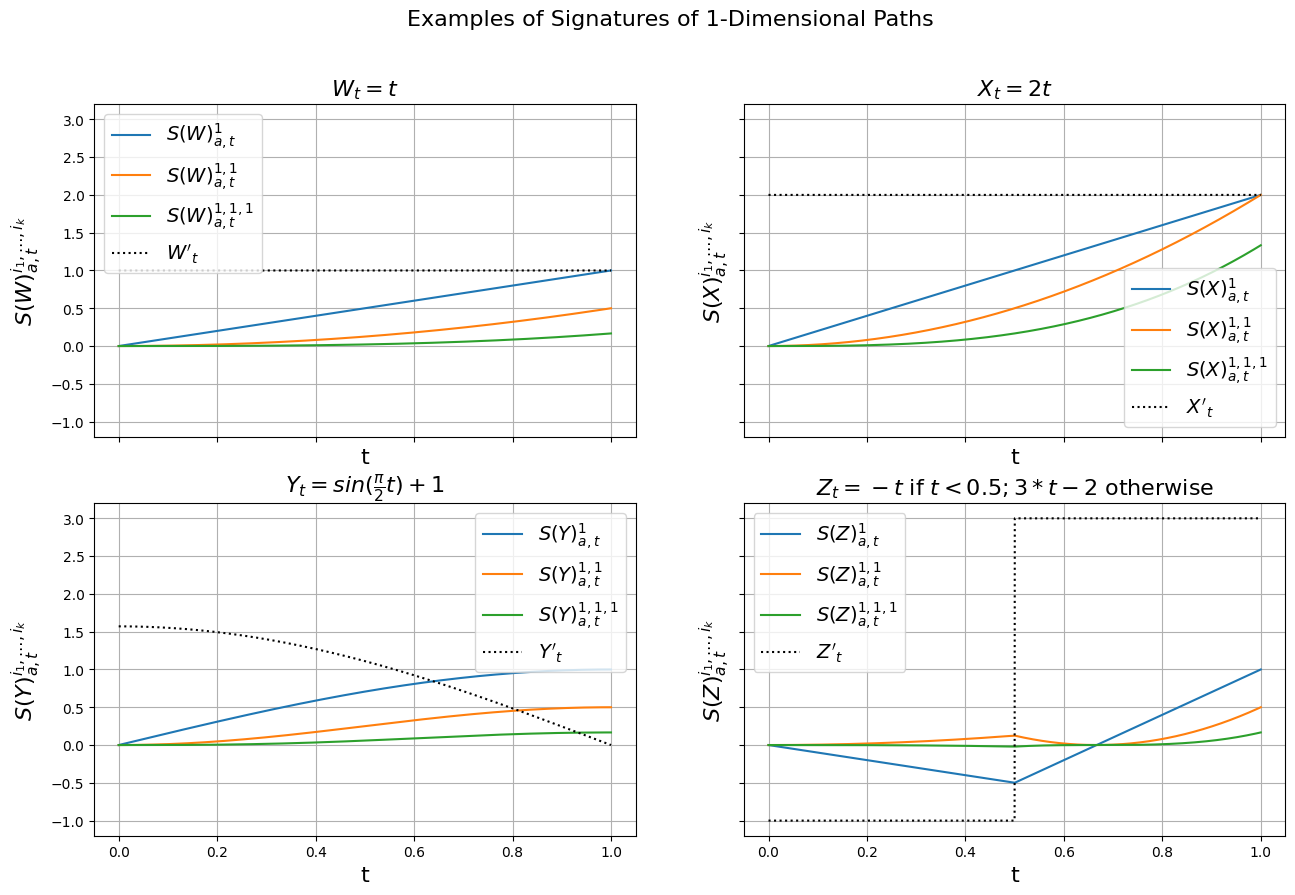

In [9]:
def compute_path_signature(X, a=0, b=1, level_threshold=3):
    # function to compute the signature of a path
    N = len(X)
    t = np.linspace(a, b, 10**4)
    dt = t[1] - t[0]
    X_t = [Xi(t) for Xi in X]
    t = t[:-1]
    dX_t = [np.diff(Xi_t) for Xi_t in X_t]
    X_prime_t = [dXi_t / dt for dXi_t in dX_t]
    
    signature = [[np.ones(len(t))]]
    for k in range(level_threshold):
        previous_level = signature[-1]
        current_level = []
        for previous_level_integral in previous_level:
            for i in range(N):
                current_level.append(np.cumsum(previous_level_integral * dX_t[i]))
        signature.append(current_level)

    signature_terms = [list(itertools.product(*([np.arange(1, N+1).tolist()] * i)))
                       for i in range(0, level_threshold+1)]
    
    return t, X_t, X_prime_t, signature, signature_terms

def plot_path_signature(t, X_t, X_prime_t, signature, signature_terms, path_title, axs):
    # function to plot the signature of a path
    path_symbol = path_title[1]
    
    # flatten lists
    signature = [integral for level in signature for integral in level] 
    signature_terms = [term for level in signature_terms for term in level]
    
    for i, ax in enumerate(axs):
        n = i + 1
        signature_filtered, signature_terms_filtered = zip(*[(integral, term)
                                                             for integral, term in zip(signature, signature_terms)
                                                             if len(term) > 0 and term[-1] == n])
        for integral, term in zip(signature_filtered, signature_terms_filtered):
            ax.plot(t, integral, label='$S(' + path_symbol + ')_{a,t}^{' +','.join([str(v) for v in term]) + '}$')
        
        ax.plot(t, X_prime_t[i], color='black', linestyle=':', label="$" + path_symbol + "'_t$" if len(axs) == 1 else "$" + path_symbol + "'_t^{}$".format(n))
        
        if len(axs) == 1:
            ylabel = '$S(' + path_symbol + ')_{a,t}^{i_1, \ldots, i_k}$'
            title = path_title
        else:
            ylabel = '$S(' + path_symbol + ')_{a,t}^{i_1, \ldots, i_{k-1}, nnn}$'.replace('nnn', str(n))
            title = 'Signature terms ' + ylabel
        
        ax.set_title(title, fontsize=16)
        ax.set_xlabel('t', fontsize=16)
        ax.set_ylabel(ylabel, fontsize=16)
    
        ax.grid()
        ax.legend(fontsize=14)
        
paths = ((lambda t: t, '$W_t = t$'),
         (lambda t: 2 * t, '$X_t = 2t$'),
         (lambda t: np.sin(np.pi / 2 * t) + 1, '$Y_t = sin(\\frac{\\pi}{2} t) + 1$'),
         (lambda t: np.where(t < 0.5, -1 * t, 3 * t - 2), '$Z_t = -t $ if $ t < 0.5; 3 * t - 2$ otherwise'))

figure_height = 9.5
fig, axs = plt.subplots(2, 2, figsize=(figure_height * scipy.constants.golden_ratio, figure_height),
                        sharex=True, sharey=True)

for path, ax in zip(paths, axs.flatten()):
    t, X_t, X_prime_t, signature, signature_terms = compute_path_signature([path[0]])
    plot_path_signature(t, X_t, X_prime_t, signature, signature_terms, path[1], [ax])

plt.suptitle('Examples of Signatures of 1-Dimensional Paths', fontsize=16)
plt.show()

#### Key Observations

For the path $W_t = t$, we may observe how the increment $S(W)^1_{a, t}$ (the term at level $k=1$) gives rise to subsequent terms at levels 2 and 3: Term $S(W)^{1,1}_{a, b}$ is the result of integrating the increment $S(W)^1_{a, t}$ with respect to $W_t$; analogously term $S(W)^{1,1,1}_{a, b}$ is the result of integrating $S(W)^{1,1}_{a, t}$ with respect to $W_t$. Because $W_t$ is non-decreasing, it follows that the aforementioned path signature terms are non-decreasing, when considering them as a function of $t$. Computed over the interval $[a, b]$ (as we would typically compute the signature of a path), the signature terms have the values $S(W)^{1}_{a, b} = 1$, $S(W)^{1,1}_{a, b} = 0.5$, $S(W)^{1,1,1}_{a, b} = 1/6$. As an aside: Because we may interpret this particular path $W_t$ as a cumulative distribution function, we may easily verify these values from the probabilistic interpretation of the signature:
$$
S(W)_{a,b} := (1, \text{Pr}(a < T_1^1 \leq b), \text{Pr}(a < T_1^1 \leq T_2^1 \leq b), \text{Pr}(a < T_1^1 \leq T_2^1 \leq T_3^1 \leq b), \ldots).
$$

The path $X_t$ is intended as a straightforward example to demonstrate how the signature varies when we modify the path. In contrast to $W_t$, we have $S(X)^{1}_{a,b} = S(X)^{1,1}_{a,b}$, because the increment is equal to the total area under the plot of $S(X)^1_{a, t}$ with respect to itself. As was observed for $W_t$, because $X_t$ is non-decreasing, it follows that the considered path signature terms are non-decreasing as a function of $t$.

For the path $Y_t$, note that the function $f(t) = sin(\frac{\pi}{2} t)$ is a reparametrisation of $W_t$: That is, we may define a surjective, continuous, non-decreasing function $\psi: [a, b] \to [a,b]$ for which is holds that $f(\psi(t)) = W_t$. Because path integrals are equivalent under reparameterisation of paths, it follows that their signatures are equivalent. Note that we defined $Y_t = sin(\frac{\pi}{2} t) + 1$; because we include the additive constant, $Y_t$ further serves as an example of the signature's invariance with respect to path translations.

The path $Z_t$ is intended as a more involved example of reparametrisation invariance. Although $Z_t$ changes direction unlike $W_t$, it is apparent that its total increment $S(Z)^1_{a, b}$ is identical to that of $W_t$ --- a necessary condition for signature equivalence. In fact, path $X_t$ is a reparametrisation of $Z_t$, because we may define $\psi(t) = 0~\text{if}~t < \frac{2}{3};~3(t-\frac{2}{3})~\text{otherwise}$, for which it holds that $X_t = Z_{\psi(t)}$.

### A Visual Exploration of the Signature of a 2-Dimensional Path

As a more complex example, we will next consider in a similar manner the signature of the 2-dimensional path $U_t = (U^1_t, U^2_t)$, $t \in [0, 1]$, with coordinate paths $U^1_t, U^2_t$ respectively defined as
$$
U^1_t := t~\text{if}~t<0.5;~-3 * t + 2~\text{otherwise},\\
U^2_t := \frac{1}{2}t~\text{if}~t<0.5;~\frac{1}{4}~\text{otherwise}.
$$

The plot of $U^1_t$ against $U^2_t$ resembles the digit '1': 

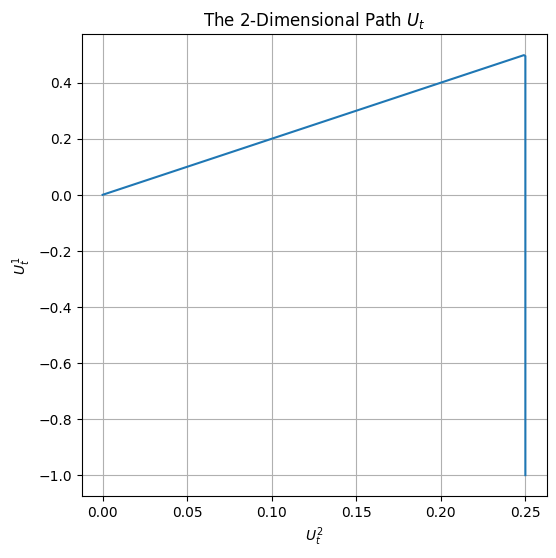

In [10]:
U = (((lambda t: np.where(t < 0.5, t, -3*t+2),
       lambda t: np.where(t < 0.5, 0.5*t, 0.25)), '$U_t'))

t = np.linspace(0, 1, 300)
U1_t = U[0][0](t)
U2_t = U[0][1](t)

figure_height = 6.0
plt.figure(figsize=(figure_height, figure_height))
plt.plot(U2_t, U1_t)
plt.xlabel('$U^2_t$')
plt.ylabel('$U^1_t$')
plt.title('The 2-Dimensional Path $U_t$')
plt.grid()
plt.show()

The following plot displays the signature up to level $K=3$; excluding the zeroth level term, for our 2-dimensional path the signature thus truncated consists of $2^1 + 2^2 + 2^3 = 14$ terms, whose indices are as follows:
* Level k=1: (1), (2)
* Level k=2: (1,1), (1,2), (2,1), (2,2)
* Level k=3: (1,1,1), (1,1,2), (1,2,1), (1,2,2), (2,1,1), (2,1,2), (2,2,1), (2,2,2)

As was undertaken previously for the 1-dimensional paths, rather than simply compute $S(\cdot)_{a, b}$ we consider the signature $S(\cdot)_{a, t}$ as a function of $t \in [a, b]$. To aid interpretation, we display two separate sub-plots,  with one sub-plot containing those terms which are path integrals with respect to $U^1_t$ and the other sub-plot containing those terms which are path integrals with respect to $U^2_t$. Furthermore, for each respective sub-plot, we alternatively include $U'^1_t$ and $U'^2_t$, the first derivative with respect to $t$ of each coordinate path in $U_t$: 

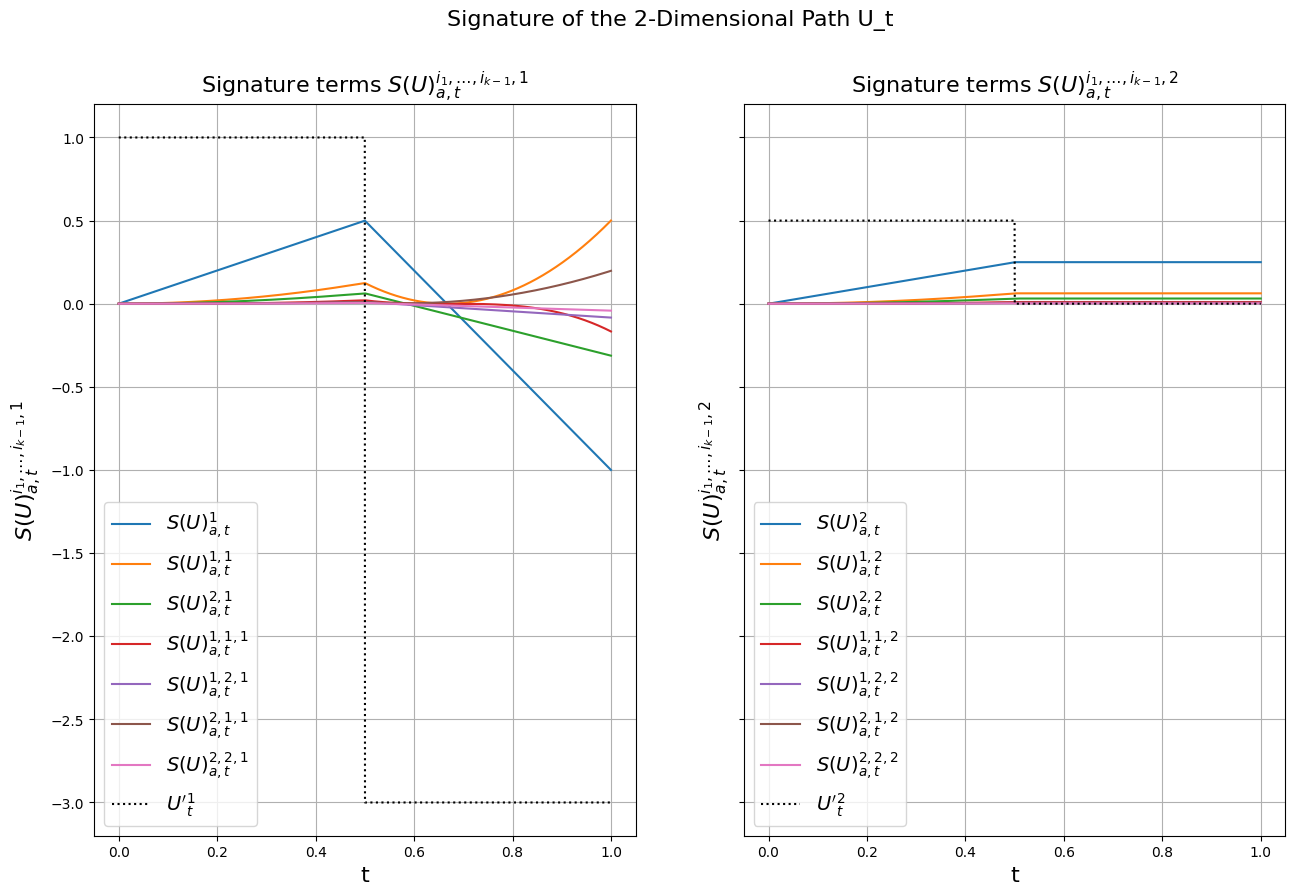

In [11]:
figure_height = 9.5
fig, axs = plt.subplots(1, 2, figsize=(figure_height * scipy.constants.golden_ratio, figure_height),
                        sharex=True, sharey=True)

t, U_t, U_prime_t, signature, signature_terms = compute_path_signature(U[0], a=0, b=1, level_threshold=3)
plot_path_signature(t, U_t, U_prime_t, signature, signature_terms, U[1], axs)

plt.suptitle('Signature of the 2-Dimensional Path U_t', fontsize=16)
plt.show()

#### Key Observations

From the left-hand sub-plot, note that $U^1_t = -Z_t$. As we might expect, we observe that the increment $S(U)^1_{a,t}$ is simply the reflection of $S(Z)^{1}_{a,t}$ about the horizontal axis. Notice however that $S(U)^{1,1}_{a,b} = S(Z)^{1,1}_{a,b}$, because of the positive contribution to the area from the sign change of the increment.

From the right-hand plot, a key observation is that all signature terms remain constant for $t>0.5$. This is because $U'^2_t=0$, for $t>0.5$.

## The Signature of a Stream

Recall that whereas a path is a mapping defined on a continuous interval, in practice we often deal with data streams: A stream is a sequence of points $\hat{X}=(x_1, \ldots, x_M)$ with each $x_i \in \mathbb{R}^N$ and with corresponding observation timestamps $a = t_1 < t_2 <\ldots < t_M = b$. We will use the notation $\hat{X}[i] = x_i$ to denote the dependence of $\hat{X}$ on discrete observations. In addition, we will use the superscript notation notation $\hat{X}[i] = (\hat{X}^1[i], \ldots, \hat{X}^N[i])$ to denote individual coordinate streams in $\hat{X}$. To obtain the signature of $\hat{X}$, we first obtain the $N$-dimensional path $X: [a,b] \to \mathbb{R}^N$ by interpolating between successive points in $\hat{X}$, so that $X_{t_i} = \hat{X}[i]$. We then compute the signature of the interpolated path $S(X)_{a,b}$. Thus, the signature of a stream depends on our choice of interpolation method.

Note however that because the signature is invariant to path reparametrisation, we may set the stream's observation timestamps to an arbitrary strictly increasing sequence. For this reason, besides the sequence of points $(x_1, \ldots, x_M)$ we need not supply timestamp information when visualising a stream or computing its signature. As an example, consider the handwritten digit 2 that we examined previously. The measurements that we have are a stream $\hat{W}$ consisting of $M=49$ spatial data points each of dimensionality $N=2$ and each $w_i=(x_i, y_i)$ representing a pair of horizontal/vertical coordinates. The corresponding observation timestamps for the stream are $t_1=0.001s, \ldots, t_M=1.201s$. For the purpose of computing the signature of $\hat{W}$, beyond specifying an interpolation method it is sufficient to consider the plot of $\hat{W}^2[i]$ against $\hat{W}^1[i]$:

In [12]:
print('Number of points in handwritten digit stream: {}'.format(len(df)))
print('Timestamp range: [{:.3f}, {:.3f}]'.format(min(df.index), max(df.index)))

Number of points in handwritten digit stream: 49
Timestamp range: [0.001, 1.201]


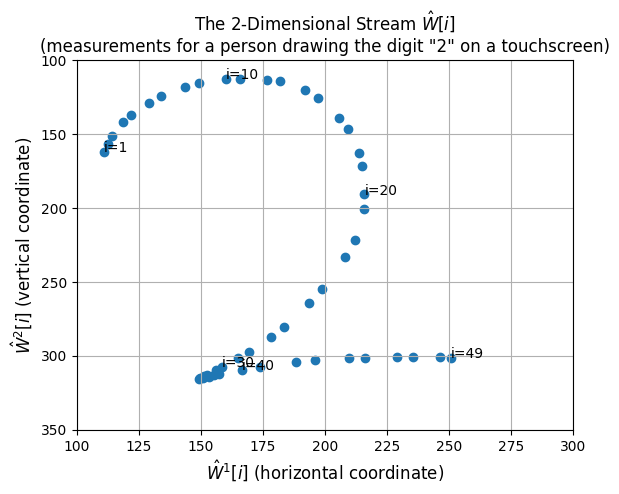

In [13]:
W1_i = df['ZX']
W2_i = df['ZY']
t_i = df.index
plt.scatter(W1_i, W2_i)
plt.xlim(100, 300)
plt.ylim(350, 100)

for i, (x, y) in enumerate(zip(W1_i, W2_i)):
    if i == 0 or i == len(W1_i) - 1 or (i+1) % 10 == 0:
        plt.text(x, y, 'i={}'.format(i+1))

plt.xlabel('$\hat{W}^1[i]$ (horizontal coordinate)', fontsize=12)
plt.ylabel('$\hat{W}^2[i]$ (vertical coordinate)', fontsize=12)
plt.title('The 2-Dimensional Stream $\hat W[i]$\n(measurements for a person drawing the digit "2" on a touchscreen)')
plt.grid()
plt.show()

## Stream Transformations

From the preceding examples of path signatures, we remarked that the signature $S(X)$ of the path $X_t$ is invariant to reparametrisation with respect to $t$. In addition, the signature is translation-invariant with respect to $X$. Both are useful properties for applications such as hand-written digit or post recognition, where we do not necessarily care about the speed at which a path is executed and its position in relation to the origin.

However, it is furthermore possible to apply a variety of transformations to streams which endow the signature with greater power. For example, a given application might require that the signature is sensitive to reparametrisation and/or translation. It is possible to satisfy those particular requirements using appropriate transformations, which we apply to our streams as a pre-processing step. That is, rather than compute the signature $S(X)_{a,b}$, we compute the signature $S(T)_{a,b}$ where $T$ is the path that we interpolate after transforming our input stream $\hat{X}$ to the stream $\hat{T}$. In this way, we modify the properties and behaviour of the signature taken as a function of $X$. The following section provides an non-exhaustive overview of transformations.

### Time-integrated Transformation

Besides being invariant to reparametrisation and translation, it turns out that the signature is invariant to retracing of path segments (Hambly and Lyons, 2010), as might for example arise from periodic movement (clapping, walking etc.) However, to ensure signature uniqueness up to path translation, it is sufficient to transform the path $X$ to include a strictly increasing coordinate path. Should we wish the path signature to be sensitive to reparametrisation (i.e. the speed of execution is relevant to our application) and retracing, the **time-integrated transformation** $\hat{T}_{\text{time}}$ consists of including the timestamps $t_1, \ldots, t_M$ of our observations $\hat{X} =(x_1, \ldots, x_M)$ as a strictly increasing coordinate stream:
$$
\hat{T}_{\text{time}}(\hat{X}) = ((t_1, x_1), \ldots, (t_M, x_M)).
$$

The following figure displays the effect of applying the time-integrated transformation to stream $\hat{W}$ as previously defined, based on plotting $t$ (the _temporal_/_time_ coordinate), $X_{t}^{(1)}$ (the _horizontal_ coordinate) and $X_{t}^{(2)}$ (the _vertical_ coordinate) against each other:

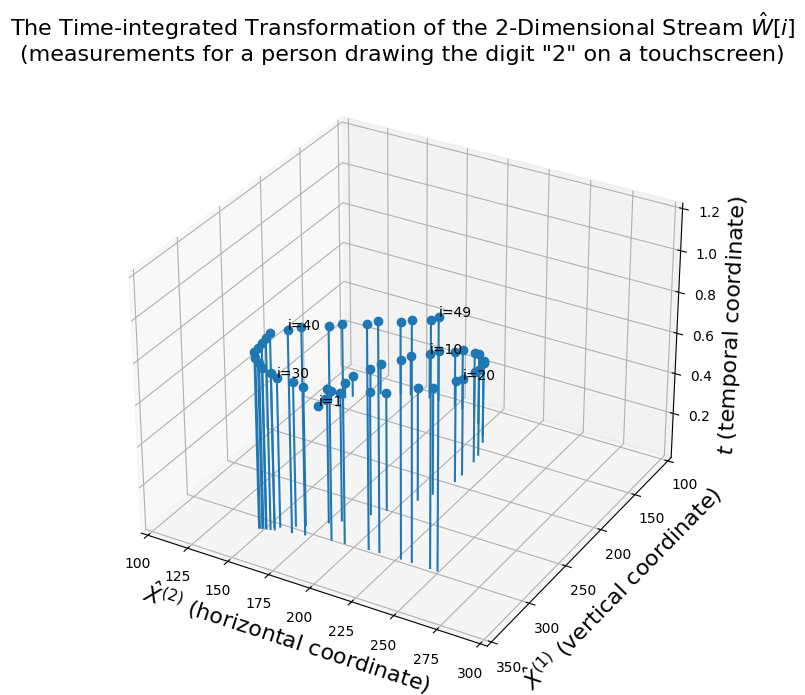

In [14]:
time_integrated_transformation = lambda t_i, W_i: np.vstack((t_i, W_i))

figure_height=8.0
fig = plt.figure(figsize=(figure_height * scipy.constants.golden_ratio, figure_height))
ax = fig.add_subplot(111, projection='3d')

def plot_stem3d(x, y, z, ax):
    for i, (xi, yi, zi) in enumerate(zip(x, y, z)):        
        line=art3d.Line3D(*zip((xi, yi, 0), (xi, yi, zi)), marker='o', markevery=(1, 1))
        ax.add_line(line)

        if i == 0 or i == len(x) - 1 or (i+1) % 10 == 0:
            ax.text(xi, yi, zi, 'i={}'.format(i+1))

W_i = np.array(df[['ZX', 'ZY']]).T
t_i = df.index

T_time = time_integrated_transformation(t_i, W_i)
plot_stem3d(x=T_time[1],
            y=T_time[2],
            z=T_time[0],
            ax=ax)

ax.set_xlabel('$\hat{X}^{(2)}$ (horizontal coordinate)', fontsize=16)
ax.set_ylabel('$\hat{X}^{(1)}$ (vertical coordinate)', fontsize=16)
ax.set_zlabel('$t$ (temporal coordinate)', fontsize=16)
plt.title('The Time-integrated Transformation of the 2-Dimensional Stream $\hat W[i]$\n(measurements for a person drawing the digit "2" on a touchscreen)',
          fontsize=16)
ax.set_xlim3d(100, 300)
ax.set_ylim3d(350, 100)
ax.set_zlim3d(min(t_i), max(t_i))

plt.grid()
plt.show()

### Invisibility Reset Transformation
The signature of a path is invariant to path translation. As proposed by Wu et al. (2020), for the case where we require sensitivity to translation for the stream $\hat{X} =(x_1, \ldots, x_M)$ with corresponding observation timestamps $a = t_1 < t_2 <\ldots < t_M = b$, the **invisibility reset transformation** $\hat{T}_{\text{inv-reset}}$ appends two points $x_{M+1} = x_M$ and $x_{M+2} = \mathbf{0}$ with respective timestamps $t_{M+1} = t_M + 1$, $t_{M+2} = t_M + 2$, in addition to a binary-valued coordinate stream:
$$
\hat{T}_{\text{inv-reset}}(\hat{X}) = ((x_1, 0), \ldots, (x_M, 0), (x_{M+1}, 1), (x_{M+2}, 1)).
$$

The following figure displays the effect of applying the invisibility reset transformation to stream $\hat{W}$ as previously defined. From the perspective of the interpolated path $W$, the invisibility reset transformation is akin to drawing with a 'pen' on a flat sheet of paper, then lifting the pen to unit height and returning it to an 'ink well' with unit height placed at the origin:

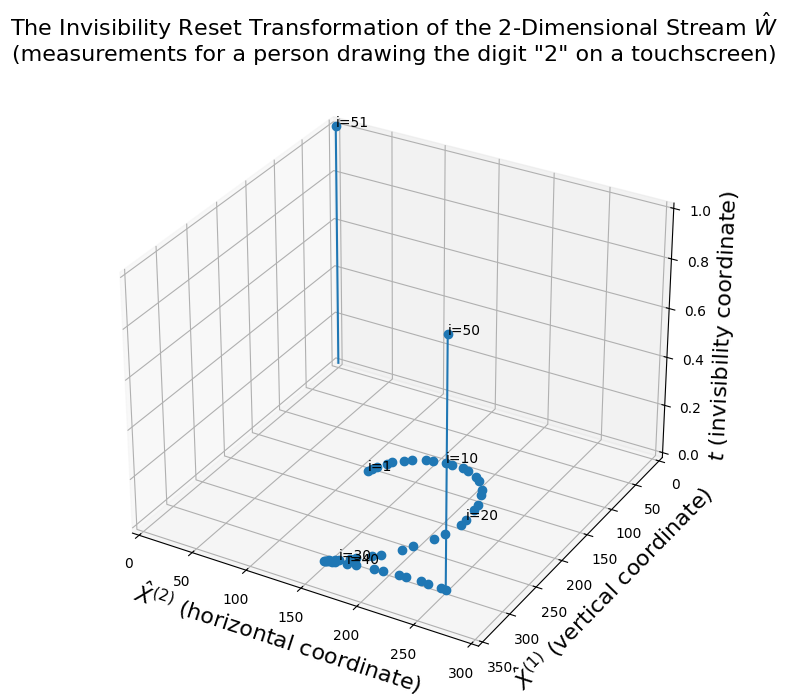

In [15]:
def invisibility_reset_transformation(W_i):
    W_i = np.hstack((W_i, W_i[:, -1:]))
    W_i = np.hstack((W_i, np.zeros((2, 1))))
    invisibility_indicator = np.zeros(W_i.shape[1])
    invisibility_indicator[-2:] = 1
    
    return np.vstack((W_i, invisibility_indicator))

figure_height=8.0
fig = plt.figure(figsize=(figure_height * scipy.constants.golden_ratio, figure_height))
ax = fig.add_subplot(111, projection='3d')

W_i = np.array(df[['ZX', 'ZY']]).T
t_i = df.index

T_time = invisibility_reset_transformation(W_i)
plot_stem3d(x=T_time[0],
            y=T_time[1],
            z=T_time[2],
            ax=ax)

ax.set_xlabel('$\hat{X}^{(2)}$ (horizontal coordinate)', fontsize=16)
ax.set_ylabel('$\hat{X}^{(1)}$ (vertical coordinate)', fontsize=16)
ax.set_zlabel('$t$ (invisibility coordinate)', fontsize=16)
plt.title('The Invisibility Reset Transformation of the 2-Dimensional Stream $\hat W$\n(measurements for a person drawing the digit "2" on a touchscreen)',
          fontsize=16)
ax.set_xlim3d(0, 300)
ax.set_ylim3d(350, 0)
ax.set_zlim3d(0, 1)

plt.grid()
plt.show()

### Lead-Lag Transformation
For obvious practical reasons, we compute signatures truncated to level $K$. With the aim of obtaining useful feature representations, depending on the application it may be beneficial to compute the **lead-lag transformation**. Applied to the stream $\hat{X} = (x_1, \ldots, x_M)$, we define the lead transformation $\hat{T}_\text{lead}$ as
$$
\hat{T}_\text{lead}(\hat{X}) = (x_1, x_2, x_2, x_3, x_3, \ldots, x_{M-1}, x_{M-1}, x_M, x_M) = (u_1, \ldots, u_{2M-1})
$$
and the lag transformation $\hat{T}_\text{lag}$ as
$$
\hat{T}_\text{lag}(\hat{X}) = (x_1, x_1, x_2, x_2, x_3, x_3, \ldots, x_{M-1}, x_{M-1}, x_M) = (v_1, \ldots, v_{2M-1}).
$$

The lead-lag transformation $\hat{T}_{\text{lead-lag}}$ consists of stacking the lead-transformed and lag-transformed versions of $\hat{X}$,
$$
\hat{T}_{\text{lead-lag}}(\hat{X}) = ((u_1, v_1), \ldots, (u_{2M-1}, v_{2M-1})).
$$

Based on the 1-dimensional stream $\hat{V}=(30, 25, 20, 40, 10)$ consisting of $M=5$ observations, the following figure displays the effect of applying the lead-lag transformation. Notice how the coordinates of points $\hat{T}_{\text{lead-lag}}(\hat{V})[j], j\in \{1, 3, 5, \ldots, 2M-1\}$ of the lead-lag transformed stream are identical to those of the original stream:

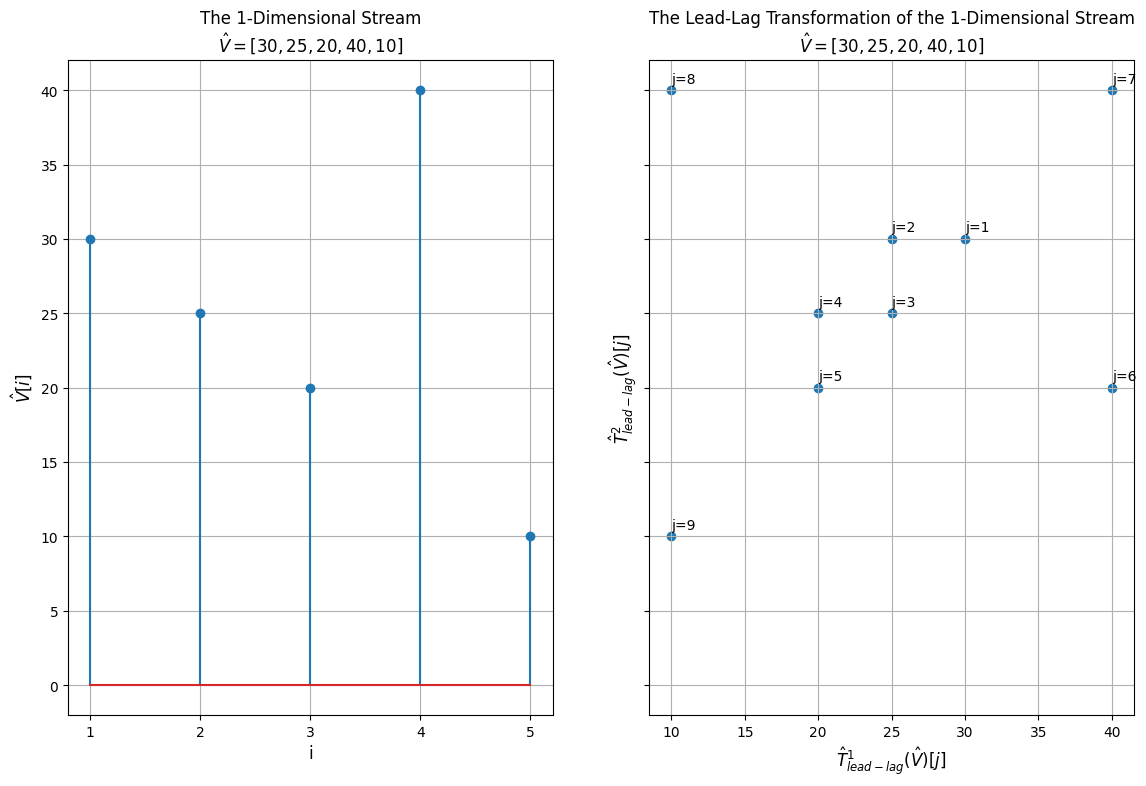

In [16]:
def lead_lag_transformation(V_i):
    V_i = np.repeat(V_i, 2)
    
    return np.vstack((V_i[1:], V_i[:-1]))

V_i = [30, 25, 20, 40, 10]
i = range(1, len(V_i) + 1)

figure_height = 8.5
fig, axs = plt.subplots(1, 2, figsize=(figure_height * scipy.constants.golden_ratio, figure_height),
                        sharex=False, sharey=True)

axs[0].stem(i, V_i)
axs[0].set_xticks(i)
axs[0].set_xlabel('i', fontsize=12)
axs[0].set_ylabel('$\hat{V}[i]$', fontsize=12)
axs[0].set_title('The 1-Dimensional Stream\n$\hat V = {}$'.format(V_i))
axs[0].grid()

T_leadlag = lead_lag_transformation(V_i)
axs[1].scatter(T_leadlag[0], T_leadlag[1], alpha=1)
axs[1].set_xlabel('$\hat{T}^1_{lead-lag}(\hat{V})[j]$', fontsize=12)
axs[1].set_ylabel('$\hat{T}^2_{lead-lag}(\hat{V})[j]$', fontsize=12)
axs[1].set_title('The Lead-Lag Transformation of the 1-Dimensional Stream\n$\hat V = {}$'.format(V_i))
axs[1].grid()

for i, (xi, yi) in enumerate(zip(T_leadlag[0], T_leadlag[1])):
    axs[1].text(xi, yi+0.5, 'j={}'.format(i+1))
        
plt.show()

### Cumulative Sum

With the aim of using the truncated signature as a useful feature representation, in addition to the lead-lag transformation we may compute the cumulative sum of coordinate streams in $\hat{X}$. That is, we define the **cumulative sum transformation** $\hat{T}_{\text{csum}}$ of the coordinate stream $\hat{X}^n$ as
$$
\hat{T}_{\text{csum}}(\hat{X}^n) = (\hat{c}_1, \ldots, \hat{c}_M),\\
c_m = \sum_{i=1}^m \hat{X}^n[i].
$$

The following figure displays the effect of applying the cumulative sum transformation to stream $\hat{V}$ as previously defined:

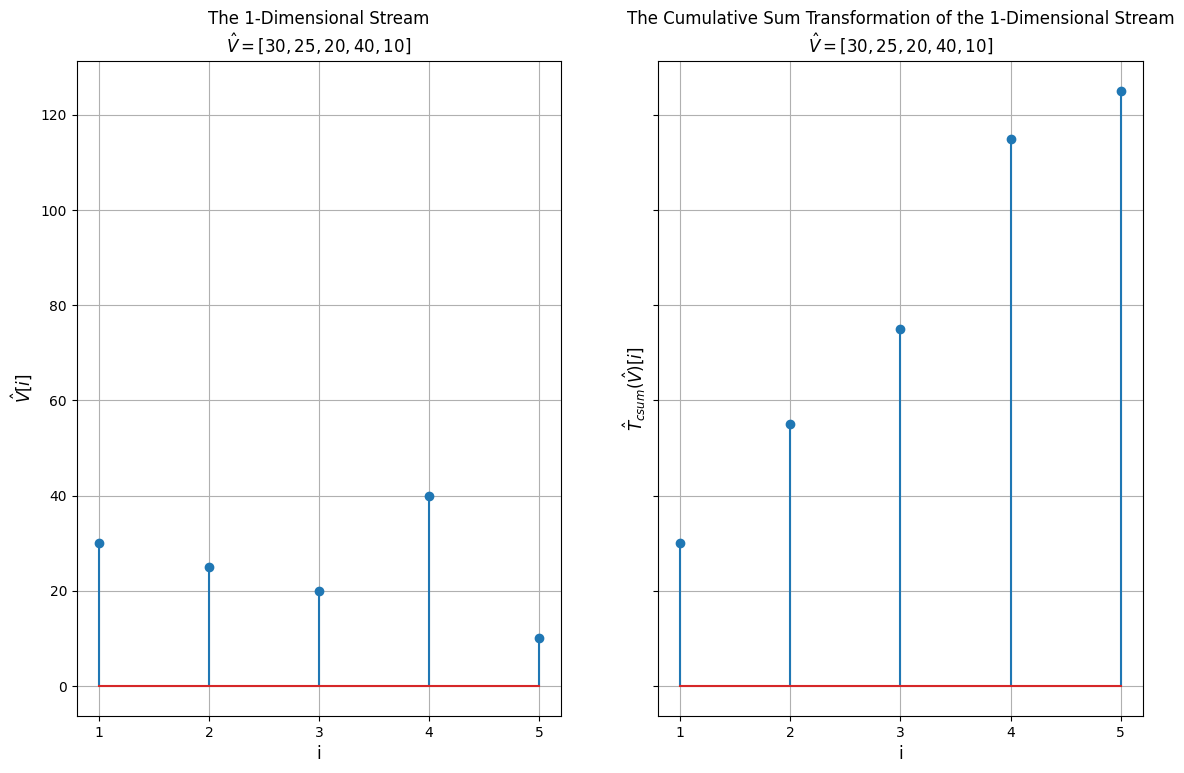

In [17]:
def cumulative_sum_transformation(V_i):    
    return np.cumsum(V_i)

V_i = [30, 25, 20, 40, 10]
i = range(1, len(V_i) + 1)

figure_height = 8.5
fig, axs = plt.subplots(1, 2, figsize=(figure_height * scipy.constants.golden_ratio, figure_height),
                        sharex=False, sharey=True)

axs[0].stem(i, V_i)
axs[0].set_xticks(i)
axs[0].set_xlabel('i', fontsize=12)
axs[0].set_ylabel('$\hat{V}[i]$', fontsize=12)
axs[0].set_title('The 1-Dimensional Stream\n$\hat V = {}$'.format(V_i))
axs[0].grid()

T_csum = cumulative_sum_transformation(V_i)
axs[1].stem(i, T_csum)
axs[1].set_xticks(i)
axs[1].set_xlabel('i', fontsize=12)
axs[1].set_ylabel('$\hat{T}_{csum}(\hat{V})[i]$', fontsize=12)
axs[1].set_title('The Cumulative Sum Transformation of the 1-Dimensional Stream\n$\hat V = {}$'.format(V_i))
axs[1].grid()
        
plt.show()

### Missing Data Transformation

Stream transformations provide us with an elegant means of dealing with missing data. Similar to the invisibility reset transformation, one possible approach described by Chevyrev and Kormilitzin (2016) involves incorporating an additional coordinate stream $\hat{Y}=(y_1, \ldots, y_M)$ to indicate the presence of missing data in the stream $\hat{X} = (x_1, \ldots, x_M)$, with $\hat{Y}[i] = 1$ if $\hat{X}[i]$ is marked as missing, $\hat{Y}[i] = 0$ otherwise. Furthermore, if observation $\hat{X}[i]$ is marked as missing, we replace it e.g. with $\hat{X}[j]$ such that $j < i$ is the largest value for which $\hat{X}[j]$ is not marked as missing.

The following figure displays the effect of applying the aforementioned variant of the **missing data transformation** $\hat{T}_{\text{missing}}$ to stream $\hat{W}$ (representing measurements for the handwritten digit 2). For the plot, we mark every 10th point in $\hat{W}$ as missing. In the plot, the first two dimensions correspond to horizontal and vertical coordinates (with missing observations replaced with their predecessors), whereas the third dimension is the 'data missing' coordinate stream $\hat{Y}$:

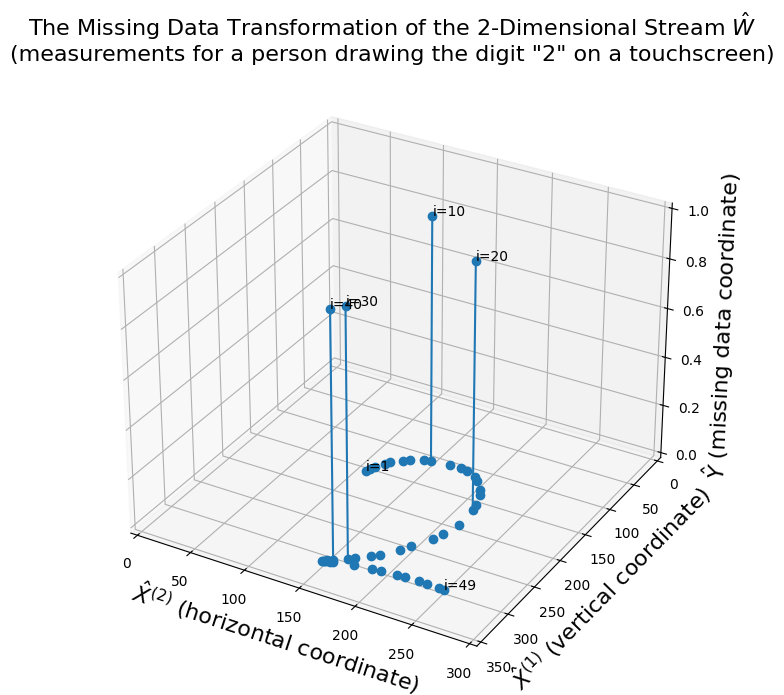

In [18]:
def missing_data_transformation(W_i):
    missing_value_indices = np.array(range(0, W_i.shape[1], 10)[1:], dtype=int) - 1
    # Mark every 10th point as missing
    W_i[:, missing_value_indices] = np.nan
    # Replace missing observations with their predecessors
    W_i[:, missing_value_indices] = W_i[:, missing_value_indices - 1]
    missing_value_mask = np.zeros(W_i.shape[1])
    missing_value_mask[missing_value_indices] = 1
    
    return np.vstack((W_i, missing_value_mask))

figure_height=8.0
fig = plt.figure(figsize=(figure_height * scipy.constants.golden_ratio, figure_height))
ax = fig.add_subplot(111, projection='3d')

W_i = np.array(df[['ZX', 'ZY']]).T
t_i = df.index

T_missing = missing_data_transformation(W_i)
plot_stem3d(x=T_missing[0],
            y=T_missing[1],
            z=T_missing[2],
            ax=ax)

ax.set_xlabel('$\hat{X}^{(2)}$ (horizontal coordinate)', fontsize=16)
ax.set_ylabel('$\hat{X}^{(1)}$ (vertical coordinate)', fontsize=16)
ax.set_zlabel('$\hat{Y}$ (missing data coordinate)', fontsize=16)
plt.title('The Missing Data Transformation of the 2-Dimensional Stream $\hat W$\n(measurements for a person drawing the digit "2" on a touchscreen)',
          fontsize=16)
ax.set_xlim3d(0, 300)
ax.set_ylim3d(350, 0)
ax.set_zlim3d(0, 1)

plt.grid()
plt.show()

### Path Disintegration
For the purpose of representing local structure, rather than compute the truncated signature of the entire path it may by advantageous to consider the truncated signatures of subpaths obtained by partitioning the path's domain $[a,b]$. One possible hierarchical approach involves dyadic intervals, or sliding windows (see for example Yang et al., 2017).

## Software Libraries for Computing Signatures

There are several software libraries which provide efficient and easy-to-use implementations of the signature method. The following list provides a brief overview:

* [`RoughPy`](https://pypi.org/project/RoughPy/) is a Python package for working with streaming data as rough paths, and working with algebraic objects such as free tensors, shuffle tensors, and elements of the free Lie algebra. At time of writing, the `RoughPy` library is currently in an alpha stage, and features are continously being added. License: BSD-3-Clause
* [`esig`](https://pypi.org/project/esig/) is a Python wrapper around the C++ libalgebra code for computing signatures of piecewise linear paths. At the time of writing, `esig` is especially efficient when dealing with sparse data, i.e. high-dimensional paths which only move in a small subset of their dimensions. License: GPLv3
* [`iisignature`](https://pypi.org/project/iisignature/) is a Python/C++ implementation of signatures of piecewise linear paths. At the time of writing, `iisignature` is especially efficient when dealing with dense data, i.e. paths which move in all of their dimensions. In addition, iisignature provides routines for signature differentiation. License: MIT
* [`signatory`](https://pypi.org/project/signatory/) is a Python/C++/PyTorch implementation of signatures of piecewise linear paths. At the time of writing, `signatory` is not currently being updated and only provides support up to PyTorch 1.9.0. Provides GPU support. License: Apache-2.0
* [`signax`](https://pypi.org/project/signax/) is a Python/JAX implementation of signatures of piecewise linear paths inspired by the `signatory` library. Provides GPU support. License: MIT

## Conclusion
Path signatures are a flexible and powerful means of obtaining fixed-length features of multi-dimensional time series, by computing computing iterated path integrals. Path signatures may be applied regardless of whether the time series of interest are evenly spaced in time. Moreover, it is possible to modify the properties and behaviour of signatures as required, by applying path transformations as a pre-processing step. In this way, it is possible for example to select the properties of shift sensitivity and reparametrisation sensitivity. Using transformations, signatures additionally provide a straightforward representation of missing data.

The focus of this notebook is on introducing the concepts of paths and streams, the path signature, and path transformations. In addition to reviewing the literature referenced, those seeking to apply path signatures to their problem domain may wish to view the [examples provided on the DataSig website](https://datasig.ac.uk/examples).

# References
Arribas, I.P., Goodwin, G.M., Geddes, J.R., Lyons, T. and Saunders, K.E., 2018. A signature-based machine learning model for distinguishing bipolar disorder and borderline personality disorder. Translational Psychiatry, 8(1), pp.1-7.

Chen, K.T., 1958. Integration of paths--A faithful representation of paths by noncommutative formal power series. Transactions of the American Mathematical Society, 89(2), pp.395-407.

Chevyrev, I. and Kormilitzin, A., 2016. A primer on the signature method in machine learning. arXiv preprint arXiv:1603.03788.

Chevyrev, I., Nanda, V. and Oberhauser, H., 2018. Persistence paths and signature features in topological data analysis. IEEE transactions on pattern analysis and machine intelligence 42.1 (2018): 192-202.

Corr, P.J., Silvestre, G.C. and Bleakley, C.J., 2017. Open source dataset and deep learning models for online digit gesture recognition on touchscreens. arXiv preprint arXiv:1709.06871.

Diehl, J., 2013. Rotation invariants of two dimensional curves based on iterated integrals. arXiv preprint arXiv:1305.6883.

Graham, B., 2013. Sparse arrays of signatures for online character recognition. arXiv preprint arXiv:1308.0371.

Gyurkó, L.G., Lyons, T., Kontkowski, M. and Field, J., 2013. Extracting information from the signature of a financial data stream. arXiv preprint arXiv:1307.7244.

Hambly, B. and Lyons, T., 2010. Uniqueness for the signature of a path of bounded variation and the reduced path group. Annals of Mathematics, pp.109-167.

Lemercier, M., Salvi, C., Damoulas, T., Bonilla, E.V. and Lyons, T., 2020. Distribution regression for continuous-time processes via the expected signature. arXiv preprint arXiv:2006.05805.

Lyons, T.J., 1998. Differential equations driven by rough signals. Revista Matemática Iberoamericana, 14(2), pp.215-310.

Morrill, J., Kormilitzin, A., Nevado-Holgado, A., Swaminathan, S., Howison, S. and Lyons, T., 2019. The signature-based model for early detection of sepsis from electronic health records in the intensive care unit. In 2019 Computing in Cardiology (CinC).

Oberhauser, H. and Schell, A., 2021. Nonlinear Independent Component Analysis for Continuous-Time Signals. arXiv preprint arXiv:2102.02876.

Wang, B., Liakata, M., Ni, H., Lyons, T., Nevado-Holgado, A. J., and Saunders, K., 2019. A path signature approach for speech emotion recognition. Interspeech 2019 (pp. 1661-1665). 

Wu, Y., Ni, H., Lyons, T.J. and Hudson, R.L., 2020. Signature features with the visibility transformation. arXiv preprint arXiv:2004.04006.

Yang, W. and Lyons, T. and Ni, H. and Schmid, C. and Jin, L., 2017. Developing the path signature methodology and its application to landmark-based human action recognition. arXiv preprint arXiv:1707.03993.

Yin, F., Wang, Q.F., Zhang, X.Y. and Liu, C.L., 2013. ICDAR 2013 Chinese handwriting recognition competition. In 2013 12th International Conference on Document Analysis and Recognition (pp. 1464-1470).